# **Amazon Product Recommendation System**

## **Project Overview:**

This project focuses on building a recommendation system using Amazon product reviews data. The dataset includes user ratings for various electronic products but excludes product details and review texts to maintain neutrality in model development.


## **Context:**
With the rapid growth of digital information, consumers are often overwhelmed with choices, leading to decision fatigue. Recommendation systems play a crucial role in personalizing user experiences by suggesting relevant products based on user preferences. Major e-commerce platforms like Amazon, Walmart, Target, and Etsy leverage sophisticated recommendation algorithms to enhance customer engagement and improve sales.

Amazon, in particular, is well known for its highly accurate recommendation system, which utilizes AI-driven techniques to analyze customer behavior. One of Amazon’s core recommendation approaches is item-to-item collaborative filtering, which effectively scales to large datasets while providing real-time personalized suggestions.


## **Objective**
The objective of this project is to develop a product recommendation system that suggests relevant items to users based on their previous ratings. By analyzing Amazon’s user-product interactions, the goal is to extract meaningful insights and build a recommendation model that enhances the online shopping experience.


## **Dataset Description**
The dataset used in this project consists of user ratings for various products. The key attributes include:

- **userId:** – A unique identifier assigned to each user.
- **productId:** – A unique identifier assigned to each product.
- **Rating:** – The numerical rating provided by a user for a specific product.
- **timestamp:** – The time at which the rating was given (not used in this analysis).


## **Setting Up the Environment**

For this project, we use the Surprise library, a popular tool for building recommendation systems. However, installing Surprise in Jupyter Notebook can sometimes lead to compatibility issues. To ensure a smooth workflow, it is recommended to use **Google Colab**, which provides a pre-configured cloud environment with necessary dependencies.

To begin, we start by mounting Google Drive in Colab to access and store project files efficiently.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [3]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.4 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505174 sha256=f3d451babe7d211e3797fe5ad56cd35a80fb02ddebb86ff735a4c09bf750c3b4
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [1]:
import pandas as pd # Importing pandas for data manipulation and analysis
import numpy as np # Importing numpy for numerical operations
import matplotlib.pyplot as plt # Importing matplotlib for data visualization
from collections import defaultdict # Importing defaultdict for handling missing keys in dictionaries

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [2]:
# Loading the dataset from Google Drive into a pandas DataFrame.
data = pd.read_csv('ratings_Electronics.csv')

In [3]:
data.head() # Displays the first 5 rows

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [4]:
# Renaming columns to more meaningful names
data.rename(columns={'AKM1MP6P0OYPR': 'user_id', '0132793040': 'prod_id', '5.0': 'rating', '1365811200': 'timestamp'}, inplace=True)

In [5]:
data.head() # Displays the first 5 rows

,user_id,prod_id,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [6]:
# Deletes the 'timestamp' column from the DataFrame as it is not required for analysis.
del data['timestamp']

In [7]:
# Creates a copy of the original dataset.
df = data.copy()

In [8]:
df.head() # Displays the first 5 rows

,user_id,prod_id,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [9]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [10]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [11]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [12]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_prods = []

for prod, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_prods.append(prod)

df_final = df.loc[~ df.prod_id.isin(remove_prods)]

In [13]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

**To understand the structure of the dataset, we first check the number of rows and columns. This helps in assessing the dataset’s size and determining the feasibility of different recommendation techniques.**

In [14]:
# Check the number of rows and columns and provide observations
df_final.shape

(65290, 3)

**This data stet has 65290 rows and 3 columns. It means a lot of rows has been filtered and deleted since we just keep the users with at least 50 ratings and the products with at least 5 ratings**

### **Data types**

In [15]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**There are 65290 rows and 3 columns. Among the three columns, the rating column is numeric and the user_id and prod_id is not numeric (object)**

### **Checking for missing values**

In [16]:
# Check for missing values present and provide observations
df_final.isna().any()

user_id    False
prod_id    False
rating     False
dtype: bool

In [17]:
df_final.isna().any().sum()

0

**There is no missing value in the df_final data set**



In [18]:
# Identifies and displays all duplicate rows in the DataFrame 'df_final'.
df_final[df_final.duplicated()]

,user_id,prod_id,rating


In [19]:
# Counts the number of duplicate rows in the DataFrame 'df_final'
df_final.duplicated().sum()

0

**There is no duplicated rows in this dataset**

### **Summary Statistics**

In [20]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].describe()

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

**The The mean of ratings is 4.29 out of 5 which is a high number while the standard deviation is 0.988. When we check the quartiles, it shows that at least 50% of the ratings are 5 while at most 25% of the ratings is below 4. Also the minimum rating is 1.**

### **Checking the rating distribution**

In [24]:
# Counts the occurrences of each unique rating value in the 'rating' column.
df_final['rating'].value_counts(dropna=False)

,count
rating,
5.0,36315
4.0,18127
3.0,6481
2.0,2515
1.0,1852


**Here is the number of rating for each rating value. The number of 5 and then 4 are significantly higher than the others.**

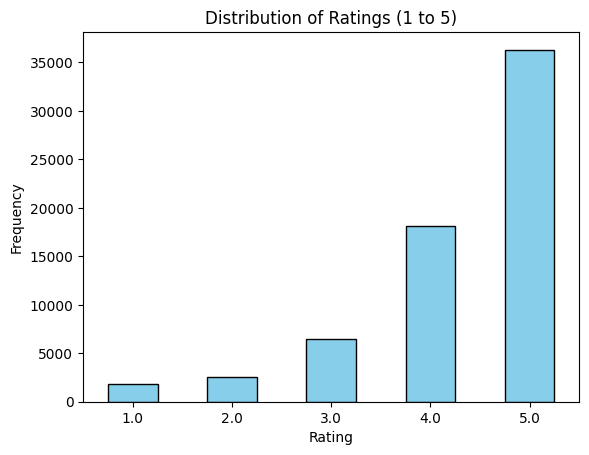

In [25]:
# Create the bar plot and provide observations
# Counts the occurrences of each unique rating, sorts them in ascending order, and plots them as a bar chart.
df_final['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
# Label for the x-axis
plt.xlabel('Rating')
# Label for the y-axis
plt.ylabel('Frequency')
# Title of the chart
plt.title('Distribution of Ratings (1 to 5)')
# Keep x-axis labels readable
plt.xticks(rotation=0)
# Displays the plot
plt.show()

**As we expect from the first analysis, most of the ratings is 5 and after that 4 is the most frequent.**

### **Checking the number of unique users and items in the dataset**

In [26]:
# Number of total rows in the data and number of unique user id and product id in the data
df_final['user_id'].describe()

,user_id
count,65290
unique,1540
top,ADLVFFE4VBT8
freq,295


**There are 1,540 unique user IDs. The most frequent user, ADLVFFE4VBT8 has 295 ratings.**

In [29]:
df_final['prod_id'].describe()

,prod_id
count,65290
unique,5689
top,B0088CJT4U
freq,206


**There are 5689 unique products, while the most rated product, B0088CJT4U, has received 206 ratings.**

### **Users with the most number of ratings**

In [21]:
# Top 10 users based on the number of ratings
df_final['user_id'].value_counts()[:10]

ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
Name: user_id, dtype: int64

In [35]:
# List of the top 10 user IDs
list(df_final['user_id'].value_counts()[:10].index)

['ADLVFFE4VBT8',
 'A3OXHLG6DIBRW8',
 'A1ODOGXEYECQQ8',
 'A36K2N527TXXJN',
 'A25C2M3QF9G7OQ',
 'A680RUE1FDO8B',
 'A1UQBFCERIP7VJ',
 'A22CW0ZHY3NJH8',
 'AWPODHOB4GFWL',
 'AGVWTYW0ULXHT']

**Above is a list of the top 10 users with the highest number of ratings. The most active user has submitted 295 ratings.**

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [36]:
# Calculate the average rating for each product
d1 = df_final.groupby(['prod_id'])['rating'].mean()
# Calculate the count of ratings for each product
d2 = df_final.groupby(['prod_id'])['rating'].count()
# Create a dataframe with calculated average and count of ratings
df_summary = pd.DataFrame({'avg_rating': d1, 'rating_count': d2})
# Sort the dataframe by average of ratings in the descending order
df_summary.sort_values(by='avg_rating', ascending=False, inplace = True)
# See the first five records of the "final_rating" dataset
df_summary.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [37]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_products (df, n_top_products, min_interaction):

  # Finding products with minimum number of interactions
  df_sorted = df.loc[df['rating_count'] > min_interaction]
  # Sorting values with respect to average rating
  df_sorted = df_sorted.sort_values(by='avg_rating', ascending=False)
  return list(df_sorted.head(n_top_products).index)

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [38]:
top_products (df_summary, n_top_products = 5, min_interaction = 50)

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [39]:
top_products (df_summary, n_top_products = 5, min_interaction = 100)

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [40]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

## **Key Concepts in Recommendation Systems**

Before building the recommendation system, it’s essential to understand some fundamental concepts that will be used throughout the project. These terms help evaluate the performance of the model and ensure that the recommendations are both relevant and useful to users.

1. **Understanding Relevant vs. Recommended Items**
   
- Relevant Item: A product is considered relevant if its actual rating exceeds a defined threshold. If the rating is below the threshold, it is considered non-relevant.
- Recommended Item: A product is recommended if its predicted rating surpasses the threshold. If the predicted rating is lower, it is not recommended to the user.

2. **Error Metrics in Recommendation Systems**
   
- False Negative (FN): The number of relevant items that were not recommended to the user. This can result in missed opportunities for businesses, as users might have been interested in those products.
- False Positive (FP): The number of irrelevant items that were mistakenly recommended. This can lead to wasted resources and a poor user experience.

3. **Performance Metrics**
Evaluating a recommendation system is crucial to ensure its effectiveness. The following metrics are commonly used to assess its performance:

- Recall: Measures the proportion of relevant items that were successfully recommended. For example, if out of 10 relevant products, 6 were recommended, the recall would be 0.60. A higher recall indicates better model performance.
- Precision: Measures how many of the recommended items were actually relevant. If 10 items were recommended and 6 turned out to be relevant, the precision would be 0.60. A higher precision means more accurate recommendations.
  
4. **Evaluating Recommendations at a Fixed ‘k’**
Since recommendation systems often generate multiple suggestions for each user, we assess their effectiveness using Precision@k, Recall@k, and F1-score@k, where ‘k’ represents the number of top recommendations provided.

- Precision@k: The fraction of relevant items among the top k recommendations. A higher value indicates that the recommendations are more relevant.
- Recall@k: The fraction of relevant items successfully recommended within the top k predictions.
- F1-score@k: The harmonic mean of Precision@k and Recall@k, balancing both metrics when they are equally important.
- 
To compute these metrics, we will implement a function that evaluates a given recommendation model, calculates Precision@k, Recall@k, and F1-score@k, and provides insights into its effectiveness. The function will consider the top k predictions for each user, helping fine-tune the recommendation system.

In [41]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):

    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Defining the Evaluation Criteria:**

To assess the effectiveness of the recommendation system, we need to establish key parameters for computing precision and recall.

- **Threshold Selection:** A rating threshold of 3.5 is used to determine whether a product is considered relevant (above 3.5) or non-relevant (below 3.5).
- **Top-k Recommendations:** The evaluation focuses on the top 10 recommendations (k=10) for each user to analyze the model’s performance in providing meaningful suggestions.

Choosing the right performance metric is crucial. The balance between precision and recall determines whether the system prioritizes relevant recommendations while minimizing false positives and false negatives. By fine-tuning these metrics, we can optimize the recommendation system for better user engagement.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [45]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))
# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [46]:
# Declaring the similarity options
sim_options = {
    "name": "cosine", # Using the cosine similarity
    "user_based": True  # True for user-user CF, False for item-item CF
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
model = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(model)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


**This user-user model gives us the precision of 0.855, recall of 0.858 and F1-score of 0.856 while the RMSE is 1.0012.**

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [47]:
# Predicting rating for a sample user with an interacted product
model.predict(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

**While the actual mrating is 5, the model predict 3.4 which is not really good prediction**

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [31]:
# Find unique user_id where prod_id is not equal to "1400501466":

# Find users who have rated prod_id = '1400501466'
users_with_prod = df_final[df_final['prod_id'] == '1400501466']['user_id'].unique()

# Get users who never rated prod_id = '1400501466'
unique_users = df_final[~df_final['user_id'].isin(users_with_prod)]['user_id'].unique()

In [32]:
list_users_not_seen_1400501466 = list(unique_users)

In [30]:
'A3LDPF5FMB782Z' in list_users_not_seen_1400501466

False

In [33]:
"A34BZM6S9L7QI4" in list_users_not_seen_1400501466

True

In [25]:
list_users_not_seen_1400501466

['A2ZR3YTMEEIIZ4',
 'A3CLWR1UUZT6TG',
 'A5JLAU2ARJ0BO',
 'A1P4XD7IORSEFN',
 'A341HCMGNZCBIT',
 'A3HPCRD9RX351S',
 'A1DQHS7MOVYYYA',
 'ALUNVOQRXOZIA',
 'A3G7BEJJCPD6DS',
 'A2JXS1JII6SAUD',
 'A1C82BC5GNABOA',
 'A1VHCO8RQFIGQJ',
 'A2Z9S2RQD542CP',
 'A2QIC4G483SQQA',
 'A3L6L5O89JTX2T',
 'A1OGCPMSIVK7G4',
 'A18HE80910BTZI',
 'A3F9CBHV4OHFBS',
 'A1T1YSCDW0PD25',
 'ABVYGB2TKBO8F',
 'A11ED8O95W2103',
 'A3NCIN6TNL0MGA',
 'ASHJAZC9OA9NS',
 'A105TOJ6LTVMBG',
 'A14JBDSWKPKTZA',
 'A3QX0ERX4D03TF',
 'A13WREJ05GMRA6',
 'A3N8O68DOEQ2FE',
 'A3J8A5L5AF5TX9',
 'A2HRHF83I3NDGT',
 'A1R3GN9MEJFXM3',
 'A3963R7EPE3A7E',
 'A2JOPUWVV0XQJ3',
 'AAW7X3GRD8GY9',
 'A3V8P0O224OBDB',
 'AY6A8KPYCE6B0',
 'A212MDP6K4VJS5',
 'A28X0LT2100RL1',
 'A1V3TRGWOMA8LC',
 'A1NZLRAZJGD99W',
 'A1522TN5FVJL0Y',
 'A3UXW18DP4WSD6',
 'A3CW0ZLUO5X2B1',
 'A3TBMGNSEQBWIL',
 'AEZJTA4KDIWY8',
 'A22CW0ZHY3NJH8',
 'A2V7EO331SFUF6',
 'A3977M5S0GIG5H',
 'A1F1A0QQP2XVH5',
 'A231WM2Z2JL0U3',
 'A2JWF9IG8PJAOA',
 'A3LWC833HQIG7J',
 'A38RMU1Y5TDP9',
 

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [51]:
# Predicting rating for a sample user with a non interacted product
model.predict(uid='A34BZM6S9L7QI4', iid='1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Based on the model's prediction, the estimated rating for user A34BZM6S9L7QI4 on item '1400501466' is 4.29**

### **Hyperparameter Tuning for the KNNBasic Algorithm**

To enhance the performance of the KNNBasic recommendation model, we fine-tune its hyperparameters. Below are some key parameters to consider:

- **k (int):** The maximum number of neighbors used for aggregation. Default is 40.
- **min_k (int):** The minimum number of neighbors required for aggregation. If fewer than min_k neighbors exist, predictions default to the global mean rating. Default is 1.
- **sim_options (dict):** A dictionary specifying the similarity measure. The available options in the Surprise library are:

    - cosine
    - msd (Mean Squared Difference, default)
    - Pearson
    - Pearson baseline

By optimizing these hyperparameters, we aim to improve the accuracy and relevance of the recommendations.

In [52]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30, 40, 50],  # Number of neighbors
    'min_k': [1, 3, 5, 10],  # Minimum neighbors
    'sim_options': {
        'name': ['cosine', 'msd', 'pearson', 'pearson_baseline'],  # Similarity measures
        'user_based': [True]  # User-User CF
    }
}
# Performing 3-fold cross-validation to tune the hyperparameters
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
# Fitting the data
grid_search.fit(data)
# Best RMSE score
best_rmse = grid_search.best_score['rmse']
print(f"Best RMSE Score: {best_rmse:.4f}")
# Combination of parameters that gave the best RMSE score
best_params = grid_search.best_params['rmse']
print("Best Hyperparameters:", best_params)

Best RMSE Score: 0.9699
Best Hyperparameters: {'k': 50, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}}


In [53]:
# Using the optimal similarity measure for user-user based collaborative filtering
best_params = grid_search.best_params['rmse']

# Creating an instance of KNNBasic with optimal hyperparameter values
best_model = KNNBasic(k=best_params['k'], min_k=best_params['min_k'], sim_options=best_params['sim_options'], verbose=False)

# Training the algorithm on the trainset
best_model.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(best_model)

RMSE: 0.9509
Precision:  0.849
Recall:  0.893
F_1 score:  0.87


**After hyperparameter tuning, the model's performance has generally improved based on the evaluation metrics.**

**Let's explore similarity options other than cosine, as the next section focuses on identifying similar users to a given user using the MSD (Mean Squared Difference) distance metric.**

In [54]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30, 40, 50],  # Number of neighbors
    'min_k': [1, 3, 5, 10],  # Minimum neighbors
    'sim_options': {
        'name': ['msd', 'pearson', 'pearson_baseline'],  # Similarity measures
        'user_based': [True]  # User-User CF
    }
}
# Performing 3-fold cross-validation to tune the hyperparameters
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
# Fitting the data
grid_search.fit(data)
# Best RMSE score
best_rmse = grid_search.best_score['rmse']
print(f"Best RMSE Score: {best_rmse:.4f}")
# Combination of parameters that gave the best RMSE score
best_params = grid_search.best_params['rmse']
print("Best Hyperparameters:", best_params)

Best RMSE Score: 0.9716
Best Hyperparameters: {'k': 50, 'min_k': 5, 'sim_options': {'name': 'msd', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [55]:
# Using the optimal similarity measure for user-user based collaborative filtering
best_params = grid_search.best_params['rmse']

# Creating an instance of KNNBasic with optimal hyperparameter values
best_model = KNNBasic(k=best_params['k'], min_k=best_params['min_k'], sim_options=best_params['sim_options'], verbose=False)

# Training the algorithm on the trainset
best_model.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(best_model)

RMSE: 0.9521
Precision:  0.849
Recall:  0.892
F_1 score:  0.87


**After hyperparameter tuning, the best model with the optimal parameters achieves improved results across all four evaluation metrics.**

### **Prediction Steps Using the Optimized Model**

To evaluate the performance of the optimized recommendation model, we follow these steps:

**1.** Predict the rating for the user with userId = "A3LDPF5FMB782Z" and productId = "1400501466" using the optimized model.

**2.** Predict the rating for the user userId = "A34BZM6S9L7QI4", who has not interacted with productId = "1400501466", using the optimized model.

**3.** Compare the results from the optimized model with predictions from the baseline model to assess improvements in recommendation accuracy.

This comparison helps determine whether hyperparameter tuning has enhanced the model’s ability to generate better recommendations.


In [56]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
best_model.predict(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.849056603773586, details={'actual_k': 5, 'was_impossible': False})

In [57]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
best_model.predict(uid='A34BZM6S9L7QI4', iid='1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**The results from the best_model indicate improved accuracy, as the predicted rating for user A3LDPF5FMB782Z and item 1400501466 increased from 3.4 to 4.849, approaching the actual rating of 5. This suggests that the model is more reliable in predicting ratings. Therefore, we can have greater confidence in the prediction for the unknown rating of user A34BZM6S9L7QI4 for item 1400501466, which is estimated to be 4.29.**

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [59]:
# 0 is the inner id of the above user
inner_user_id = 0  # Internal ID for the user

# Find 5 nearest neighbors
similar_users_inner_ids = best_model.get_neighbors(inner_user_id, k=5)

# Convert inner IDs back to raw user IDs
similar_users_raw_ids = [trainset.to_raw_uid(inner_id) for inner_id in similar_users_inner_ids]

# Display similar users
print(f"Top 5 similar users to user {trainset.to_raw_uid(inner_user_id)}:")
print(similar_users_raw_ids)

Top 5 similar users to user A20L63B48RPSOH:
['A16J281SJ9QXIQ', 'A3CJ7MHAS9IMAM', 'A2L0F2T1DLTNT8', 'AYMD77ITD15PT', 'A21I62TCDL4754']


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [60]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [61]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
get_recommendations(data= df_final, user_id= "A3LDPF5FMB782Z", top_n= 5, algo= best_model)

[('B000067RT6', 5),
 ('B000BQ7GW8', 5),
 ('B001ENW61I', 5),
 ('B001TH7GUU', 5),
 ('B001TH7T2U', 5)]

In [62]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
L = get_recommendations(data= df_final, user_id= "A3LDPF5FMB782Z", top_n= 5, algo= best_model)
recommonded_df = pd.DataFrame(L, columns = ['prod_id', 'predicted_ratings'])

In [64]:
#Check the first 5 rows of the recommonded_df dataframe
recommonded_df.head()

,prod_id,predicted_ratings
0,B000067RT6,5
1,B000BQ7GW8,5
2,B001ENW61I,5
3,B001TH7GUU,5
4,B001TH7T2U,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [65]:
# Declaring the similarity options
sim_options = {
    "name": "cosine", # Using the cosine similarity
    "user_based": False}  # True for user-user CF, False for item-item CF

# KNN algorithm is used to find desired similar items. Use random_state=1
model = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)
# Train the algorithm on the trainset, and predict ratings for the test set
model.fit(trainset)
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(model)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


**In comparison to our previous best results which were:
RMSE: 0.9521
Precision: 0.849
Recall: 0.892
F1 Score: 0.87
The current results do not appear to be as good. Let's re-evaluate after hyperparameter tuning to check for further improvements.**



Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [66]:
# Predicting rating for a sample user with an interacted product
model.predict(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

**This model performs well in predicting the known rating of 5, producing an output of 4.27.**

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [67]:
# Predicting rating for a sample user with a non interacted product
model.predict(uid='A34BZM6S9L7QI4', iid='1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**This model predicts the unknown rating for user A34BZM6S9L7QI4 and item 1400501466 will be 4.29**

### **Hyperparameter tuning the item-item similarity-based model**

To optimize the KNNBasic recommendation model, we use GridSearchCV to tune the following parameters:

- k: [10, 20, 30] (Number of neighbors for aggregation)
- min_k: [3, 6, 9] (Minimum number of neighbors for aggregation)
- sim_options:
    - name: ['msd', 'cosine'] (Similarity measures)
    - user_based: [False] (Item-based filtering)
The model is tuned using the Root Mean Squared Error (RMSE) as the evaluation metric.

After running GridSearchCV, the best score and best parameters are printed to determine the optimal configuration for improving recommendation accuracy.

In [68]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k':  [10, 20, 30],  # Number of neighbors
    'min_k': [3, 6, 9],  # Minimum neighbors
    'sim_options': {
        'name': ['msd', 'cosine'],  # Similarity measures
        'user_based': [False]  # User-User CF
    }
}
# Performing 3-fold cross validation to tune the hyperparameters
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
# Fitting the data
grid_search.fit(data)
# Find the best RMSE score
best_rmse = grid_search.best_score['rmse']
print(f"Best RMSE Score: {best_rmse:.4f}")
# Find the combination of parameters that gave the best RMSE score
best_params = grid_search.best_params['rmse']
print("Best Hyperparameters:", best_params)

Best RMSE Score: 0.9760
Best Hyperparameters: {'k': 30, 'min_k': 9, 'sim_options': {'name': 'msd', 'user_based': False}}


### **Building the Optimized Item-Item Similarity Model**

Using the **optimal values for each of those hyperparameters as best parameters**  obtained from GridSearchCV, we build the optimized item-item similarity-based model. The steps include:

1. Train the model using the optimal hyperparameters.
2. Evaluate performance by comparing the optimized model’s predictions with those from the baseline model.
3. Compare key metrics such as RMSE, precision, and recall to determine improvements in recommendation accuracy.

This comparison helps assess whether hyperparameter tuning enhances the model's effectiveness in providing better recommendations.

In [69]:
# Using the optimal similarity measure for item-item based collaborative filtering
best_params = grid_search.best_params['rmse']
# Creating an instance of KNNBasic with optimal hyperparameter values
best_model = KNNBasic(k=best_params['k'], min_k=best_params['min_k'], sim_options=best_params['sim_options'], verbose=False)
# Training the algorithm on the trainset
best_model.fit(trainset)
# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(best_model)

RMSE: 0.9567
Precision:  0.838
Recall:  0.889
F_1 score:  0.863


**We can see the tuned model is showing better results than its base model.**

### **Prediction and Model Comparison**

To evaluate the effectiveness of the optimized recommendation model, we follow these steps:
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

This comparison helps determine whether the optimized model provides better personalization and more accurate predictions than the baseline.

In [70]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
best_model.predict(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.67427701674277, details={'actual_k': 22, 'was_impossible': False})

In [71]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
best_model.predict(uid='A34BZM6S9L7QI4', iid='1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**This model accurately predicts the known rating of 5 with a value of 4.67 and also estimates the unknown rating as 4.29.**

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [72]:
# 0 is the inner id of the above item
inner_item_id = 0  # Internal ID for the item

# Find 5 most similar items (nearest neighbors)
similar_items_inner_ids = best_model.get_neighbors(inner_item_id, k=5)

# Step 3: Convert inner item IDs back to raw item IDs
similar_items_raw_ids = [trainset.to_raw_iid(inner_id) for inner_id in similar_items_inner_ids]

# Step 4: Display similar items
print(f"Top 5 similar items to item {trainset.to_raw_iid(inner_item_id)}:")
print(similar_items_raw_ids)

Top 5 similar items to item B005G0CUP2:
['B008X9Z3UC', 'B003ZSHKJ8', 'B003LSTD38', 'B005EOWBKE', 'B004IZN3WU']


**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

Using the get_recommendations() function.

In [73]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
get_recommendations(data= df_final, user_id= "A1A5KUIIIHFF4U", top_n= 5, algo= best_model)

[('1400532655', 4.292024046561495),
 ('1400599997', 4.292024046561495),
 ('9983891212', 4.292024046561495),
 ('B00000DM9W', 4.292024046561495),
 ('B00000J1V5', 4.292024046561495)]

In [74]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
L = get_recommendations(data= df_final, user_id= "A1A5KUIIIHFF4U", top_n= 5, algo= best_model)
recommonded_df = pd.DataFrame(L, columns = ['prod_id', 'predicted_ratings'])

Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

In [75]:
recommonded_df.head()

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [76]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)
# Training the algorithm on the trainset
svd.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


**This model generally outperforms the previous ones based on the evaluation metrics.**

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [77]:
# Making prediction
svd.predict(uid= 'A3LDPF5FMB782Z', iid= '1400501466', r_ui=5)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

**For predicting the known rating of 5, this model performs slightly worse than the previous ones, as the estimated output is 4.08.**

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [78]:
# Making prediction
svd.predict(uid= 'A34BZM6S9L7QI4', iid= '1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

**This model predicts a rating of 4.4 for the unknown rating of user A34BZM6S9L7QI4 for item '1400501466'.**

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [79]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}
# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.8979695791475631
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [80]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)
# Train the algorithm on the trainset
svd_optimized=svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8808
Precision:  0.854
Recall:  0.878
F_1 score:  0.866


**Here are the metric values after parameter tuning. The results remain nearly the same, with improvements in RMSE and Precision.**

### **Prediction and Model Comparison:**

To assess the performance of the optimized recommendation model, we follow these steps:

- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

This analysis helps determine whether tuning the model enhances its predictive capabilities and improves user experience.

In [81]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict(uid= 'A3LDPF5FMB782Z', iid= '1400501466', r_ui=5)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.128589011282042, details={'was_impossible': False})

In [82]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict(uid= 'A34BZM6S9L7QI4', iid= '1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.216280997100113, details={'was_impossible': False})

**The enhanced model, optimized with the best parameters, outperforms its baseline by estimating a known rating of 5 as 4.12 (instead of 4.08) and predicting 4.21 for an unknown rating.**

### **Conclusion and Recommendations**

The notebook focuses on building a product recommendation system using Amazon product reviews as the dataset. It discusses the importance of recommendation systems in reducing information overload for consumers and highlights how e-commerce platforms like Amazon use such systems to enhance user experience.


**Algorithms Used:**
- Rank-based recommendation using averages.
- User-user similarity-based collaborative filtering.
- Item-item similarity-based collaborative filtering.
- Model-based (matrix factorization) collaborative filtering.

To demonstrate the user-user, item-item, and model-based collaborative filtering methods, we leveraged the Surprise library. For each of these approaches, grid search cross-validation was applied to determine the optimal hyperparameters, which in turn improved our model performance. For instance, after tuning, the optimized user-user model achieved a precision of ~0.849, recall of ~0.892, and an F1-score of ~0.87—with a noticeable improvement in predicting a known rating (from an initial estimate of 3.4 to 4.85 for a specific user–item pair). Similarly, the item-item model and the SVD-based matrix factorization model also showed enhanced performance through hyperparameter tuning, with the latter delivering a lower RMSE (implying that the latent factor model effectively captures user and item features even when ratings are sparse).

For performance evaluation, precision@k and recall@k were used, and the corresponding F1-scores were computed for each model. Overall, the optimized user-user similarity-based recommendation system provided the best balance according to the F1-score (around 0.86–0.87), while the matrix factorization model achieved lower RMSE by accounting for latent factors—suggesting that users and items indeed reside in a lower-dimensional space that captures their intrinsic properties.

Collaborative Filtering, whether by searching for similar users or items, relies on the similarity of past interactions (e.g., reading or purchasing behavior) to make predictions. In contrast, Matrix Factorization decomposes the user–item matrix to capture latent features, enabling recommendations based on proximity in the latent space. Although the matrix factorization model yielded lower RMSE values (0.88), it sometimes underestimated ratings for products the user has already interacted with. This highlights the trade-offs between models that focus on similarity measures versus those that capture underlying latent factors.


**Conclusion:**

In this case study, we explored different recommendation system techniques, including collaborative filtering, matrix factorization, and rank-based methods. We observed that collaborative filtering models, especially user-user similarity-based approaches, performed the best in terms of recommendation accuracy.

While matrix factorization demonstrated lower RMSE due to its ability to capture latent factors, collaborative filtering proved more effective in capturing direct user preferences.

**Future improvements could include:**

Hybrid recommendation models that combine different techniques to enhance accuracy.
Content-based filtering to incorporate product attributes and user preferences.
Deep learning models such as neural collaborative filtering for more advanced predictions.
Overall, the study demonstrates the power of personalized recommendation systems and their significance in improving the e-commerce experience for users.